# 参数管理

在选择了架构并设置了超参数后，我们就进入了训练阶段。
此时，我们的目标是找到使损失函数最小化的模型参数值。
经过训练后，我们将需要使用这些参数来做出未来的预测。
此外，有时我们希望提取参数，以便在其他环境中复用它们，
将模型保存下来，以便它可以在其他软件中执行，
或者为了获得科学的理解而进行检查。

之前的介绍中，我们只依靠深度学习框架来完成训练的工作，
而忽略了操作参数的具体细节。
本节，我们将介绍以下内容：

* 访问参数，用于调试、诊断和可视化。
* 参数初始化。
* 在不同模型组件间共享参数。

(**我们首先看一下具有单隐藏层的多层感知机。**)


In [14]:
import torch
from torch import nn

net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(), nn.Linear(8, 1))
X = torch.rand(size=(2, 4))
net(X)

tensor([[-0.1780],
        [-0.1024]], grad_fn=<AddmmBackward0>)

## [**参数访问**]

我们从已有模型中访问参数。
当通过`Sequential`类定义模型时，
我们可以通过索引来访问模型的任意层。
这就像模型是一个列表一样，每层的参数都在其属性中。
如下所示，我们可以检查第二个全连接层的参数。


In [15]:
print(net[2].state_dict())

OrderedDict([('weight', tensor([[-0.3499,  0.2752,  0.0135, -0.1562, -0.2685,  0.0713, -0.1138, -0.2299]])), ('bias', tensor([-0.0780]))])


输出的结果告诉我们一些重要的事情：
首先，这个全连接层包含两个参数，分别是该层的权重和偏置。
两者都存储为单精度浮点数（float32）。
注意，参数名称允许唯一标识每个参数，即使在包含数百个层的网络中也是如此。

### [**目标参数**]

注意，每个参数都表示为参数类的一个实例。
要对参数执行任何操作，首先我们需要访问底层的数值。
有几种方法可以做到这一点。有些比较简单，而另一些则比较通用。
下面的代码从第二个全连接层（即第三个神经网络层）提取偏置，
提取后返回的是一个参数类实例，并进一步访问该参数的值。


In [16]:
print(type(net[2].bias))
print(net[2].bias)
print(net[2].bias.data)

<class 'torch.nn.parameter.Parameter'>
Parameter containing:
tensor([-0.0780], requires_grad=True)
tensor([-0.0780])


参数是复合的对象，包含值、梯度和额外信息。
这就是我们需要显式参数值的原因。
除了值之外，我们还可以访问每个参数的梯度。
在上面这个网络中，由于我们还没有调用反向传播，所以参数的梯度处于初始状态。


In [17]:
net[2].weight.grad == None

True

### [**一次性访问所有参数**]

当我们需要对所有参数执行操作时，逐个访问它们可能会很麻烦。
当我们处理更复杂的块（例如，嵌套块）时，情况可能会变得特别复杂，
因为我们需要递归整个树来提取每个子块的参数。
下面，我们将通过演示来比较访问第一个全连接层的参数和访问所有层。


In [18]:
print(*[(name, param.shape) for name, param in net[0].named_parameters()])
print(*[(name, param.shape) for name, param in net.named_parameters()])

('weight', torch.Size([8, 4])) ('bias', torch.Size([8]))
('0.weight', torch.Size([8, 4])) ('0.bias', torch.Size([8])) ('2.weight', torch.Size([1, 8])) ('2.bias', torch.Size([1]))


这为我们提供了另一种访问网络参数的方式，如下所示。


In [19]:
net.state_dict()['2.bias'].data

tensor([-0.0780])

### [**从嵌套块收集参数**]

让我们看看，如果我们将多个块相互嵌套，参数命名约定是如何工作的。
我们首先定义一个生成块的函数（可以说是“块工厂”），然后将这些块组合到更大的块中。


In [20]:
def block1():
    return nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                         nn.Linear(8, 4), nn.ReLU())

def block2():
    net = nn.Sequential()
    for i in range(4):
        # 在这里嵌套
        net.add_module(f'block {i}', block1())
    return net

rgnet = nn.Sequential(block2(), nn.Linear(4, 1))
rgnet(X)

tensor([[-0.2059],
        [-0.2059]], grad_fn=<AddmmBackward0>)

[**设计了网络后，我们看看它是如何工作的。**]


In [21]:
print(rgnet)

Sequential(
  (0): Sequential(
    (block 0): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 1): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 2): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 3): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=4, out_features=1, bias=True)
)


因为层是分层嵌套的，所以我们也可以像通过嵌套列表索引一样访问它们。
下面，我们访问第一个主要的块中、第二个子块的第一层的偏置项。


In [22]:
rgnet[0][1][0].bias.data

tensor([ 0.3605, -0.3416, -0.1150, -0.0824, -0.1706, -0.0147, -0.4996, -0.3993])

## 参数初始化

知道了如何访问参数后，现在我们看看如何正确地初始化参数。
我们在 :numref:`sec_numerical_stability`中讨论了良好初始化的必要性。
深度学习框架提供默认随机初始化，
也允许我们创建自定义初始化方法，
满足我们通过其他规则实现初始化权重。


默认情况下，PyTorch会根据一个范围均匀地初始化权重和偏置矩阵，
这个范围是根据输入和输出维度计算出的。
PyTorch的`nn.init`模块提供了多种预置初始化方法。


### [**内置初始化**]

让我们首先调用内置的初始化器。
下面的代码将所有权重参数初始化为标准差为0.01的高斯随机变量，
且将偏置参数设置为0。


In [23]:
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0, std=0.01)
        nn.init.zeros_(m.bias)
net.apply(init_normal)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([ 0.0004, -0.0105, -0.0032, -0.0021]), tensor(0.))

我们还可以将所有参数初始化为给定的常数，比如初始化为1。


In [24]:
def init_constant(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 1)
        nn.init.zeros_(m.bias)
net.apply(init_constant)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([1., 1., 1., 1.]), tensor(0.))

我们还可以[**对某些块应用不同的初始化方法**]。
例如，下面我们使用Xavier初始化方法初始化第一个神经网络层，
然后将第三个神经网络层初始化为常量值42。


In [25]:
def init_xavier(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
def init_42(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 42)

net[0].apply(init_xavier)
net[2].apply(init_42)
print(net[0].weight.data[0])
print(net[2].weight.data)

tensor([ 0.0208, -0.0403, -0.3590,  0.3071])
tensor([[42., 42., 42., 42., 42., 42., 42., 42.]])


### [**自定义初始化**]

有时，深度学习框架没有提供我们需要的初始化方法。
在下面的例子中，我们使用以下的分布为任意权重参数$w$定义初始化方法：

$$
\begin{aligned}
    w \sim \begin{cases}
        U(5, 10) & \text{ 可能性 } \frac{1}{4} \\
            0    & \text{ 可能性 } \frac{1}{2} \\
        U(-10, -5) & \text{ 可能性 } \frac{1}{4}
    \end{cases}
\end{aligned}
$$


同样，我们实现了一个`my_init`函数来应用到`net`。


In [26]:
def my_init(m):
    if type(m) == nn.Linear:
        print("Init", *[(name, param.shape)
                        for name, param in m.named_parameters()][0])
        nn.init.uniform_(m.weight, -10, 10)
        m.weight.data *= m.weight.data.abs() >= 5

net.apply(my_init)
net[0].weight[:2]

Init weight torch.Size([8, 4])
Init weight torch.Size([1, 8])


tensor([[-6.1768,  7.4800,  5.9326, -5.7906],
        [-0.0000,  0.0000,  0.0000,  0.0000]], grad_fn=<SliceBackward0>)

注意，我们始终可以直接设置参数。


In [27]:
net[0].weight.data[:] += 1
net[0].weight.data[0, 0] = 42
net[0].weight.data[0]

tensor([42.0000,  8.4800,  6.9326, -4.7906])

## [**参数绑定**]

有时我们希望在多个层间共享参数：
我们可以定义一个稠密层，然后使用它的参数来设置另一个层的参数。


In [30]:
# 我们需要给共享层一个名称，以便可以引用它的参数
shared = nn.Linear(8, 8)
net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                    shared, nn.ReLU(),
                    shared, nn.ReLU(),
                    nn.Linear(8, 1))
net(X)
# 检查参数是否相同
print(net[2].weight.data[0] == net[4].weight.data[0])
net[2].weight.data[0, 0] = 100
# 确保它们实际上是同一个对象，而不只是有相同的值
print(net[2].weight.data[0] == net[4].weight.data[0])

tensor([True, True, True, True, True, True, True, True])
tensor([True, True, True, True, True, True, True, True])


这个例子表明第三个和第五个神经网络层的参数是绑定的。
它们不仅值相等，而且由相同的张量表示。
因此，如果我们改变其中一个参数，另一个参数也会改变。
你可能会思考：当参数绑定时，梯度会发生什么情况？
答案是由于模型参数包含梯度，因此在反向传播期间第二个隐藏层
（即第三个神经网络层）和第三个隐藏层（即第五个神经网络层）的梯度会加在一起。


## 小结

* 我们有几种方法可以访问、初始化和绑定模型参数。
* 我们可以使用自定义初始化方法。

## 练习

1. 使用 :numref:`sec_model_construction` 中定义的`FancyMLP`模型，访问各个层的参数。
1. 查看初始化模块文档以了解不同的初始化方法。
1. 构建包含共享参数层的多层感知机并对其进行训练。在训练过程中，观察模型各层的参数和梯度。
1. 为什么共享参数是个好主意？


In [55]:
from torch.nn import functional as F
#  Q1:使用 :numref:`sec_model_construction` 中定义的`FancyMLP`模型，访问各个层的参数。
class MLP(nn.Module):
    # 用模型参数声明层。这里，我们声明两个全连接的层
    def __init__(self):
        # 调用MLP的父类Module的构造函数来执行必要的初始化。
        # 这样，在类实例化时也可以指定其他函数参数，例如模型参数params（稍后将介绍）
        super().__init__()
        self.hidden = nn.Linear(20, 256)  # 隐藏层
        self.out = nn.Linear(256, 10)  # 输出层

    # 定义模型的前向传播，即如何根据输入X返回所需的模型输出
    def forward(self, X):
        # 注意，这里我们使用ReLU的函数版本，其在nn.functional模块中定义。
        return self.out(F.relu(self.hidden(X)))


X = torch.rand(2, 20)
net = MLP()
net(X)

# 
print(*[(name, param.shape) for name, param in net.named_parameters()])


('hidden.weight', torch.Size([256, 20])) ('hidden.bias', torch.Size([256])) ('out.weight', torch.Size([10, 256])) ('out.bias', torch.Size([10]))


In [65]:
# print(net.hidden.bias.data)
print(net.hidden.weight.data[0, 0])
# net.hidden.weight.data[0, 0] = 100
# print(net.hidden.weight.data[0, 0])
print(net.hidden.weight.data[0])
net.apply(my_init)
print(net)
net.hidden.weight.data[:] += 1
print(net.hidden.weight.data[:])

tensor(1.)
tensor([ 1.0000,  7.5549, -8.7168, -6.2053,  1.0000, -5.1523,  1.0000,  1.0000,
         1.0000,  9.9765,  1.0000,  1.0000, -7.7263, -8.9329, -6.9369,  1.0000,
         1.0000,  1.0000,  1.0000, -8.7215])
Init weight torch.Size([256, 20])
Init weight torch.Size([10, 256])
MLP(
  (hidden): Linear(in_features=20, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)
tensor([[ 8.1279,  1.0000,  9.9794,  ...,  1.0000,  7.7180,  8.9723],
        [ 1.0000,  1.0000,  8.4949,  ..., 10.2047,  1.0000,  1.0000],
        [ 1.0000,  1.0000,  8.1318,  ...,  1.0000,  1.0000,  1.0000],
        ...,
        [-8.0760,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
        [-6.7435,  1.0000,  1.0000,  ...,  1.0000, 10.2923,  1.0000],
        [ 1.0000,  1.0000, -8.4815,  ..., -7.2815,  1.0000,  7.6858]])


In [ ]:
# Q2: 查看初始化模块文档以了解不同的初始化方法。
# A2: https://blog.csdn.net/zyw2002/article/details/128172005

In [3]:
# Q3: 构建包含共享参数层的多层感知机并对其进行训练。在训练过程中，观察模型各层的参数和梯度。
# 共享层

from torch import nn
import torch
shared = nn.Linear(8, 8)
net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                    shared, nn.ReLU(),
                    shared, nn.ReLU(),
                    nn.Linear(8, 1))
X = torch.rand(size=(2, 4))
net(X)
print(net)

import math
import numpy as np
from d2l import torch as d2l

max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

"""评估给定数据集上模型的损失"""
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = torch.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())


Sequential(
  (0): Linear(in_features=4, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=8, bias=True)
  (5): ReLU()
  (6): Linear(in_features=8, out_features=1, bias=True)
)


AttributeError: module 'd2l.torch' has no attribute 'train_epoch_ch3'

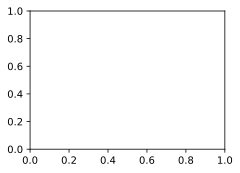

In [4]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

In [ ]:
# Q4: 为什么共享参数是个好主意？
# A4: 共享参数通常可以节省内存，并在以下方面具有特定的好处：
# 对于图像识别中的CNN，共享参数使网络能够在图像中的任何地方而不是仅在某个区域中查找给定的功能。
# 对于RNN，它在序列的各个时间步之间共享参数，因此可以很好地推广到不同序列长度的示例。
# 对于自动编码器，编码器和解码器共享参数。 在具有线性激活的单层自动编码器中，共享权重会在权重矩阵的不同隐藏层之间强制正交。

[Discussions](https://discuss.d2l.ai/t/1829)
